# 6.3 Advanced use of recurrent neural networks

In this section, we'll review three advanced techniques for improving the performance and generalization power of RNNs. 

We demonstrate all these concepts on a temperature-forcasting problem, where you have access to a timeseries of data points coming from sensors installed on the roof of a building: e.g. temperature, air pressure, humidity, which we can use to predict the temperature 24 hours later.

We'll cover the following techniques:

### 1) Recurrent dropout ---- a specific, built-in way to use dropout to fight overfitting in recurrent layers;
### 2) Stacking recurrent layers ---- increase the representational power of the network (at the cost of higher computational  loads);
### 3) Bidirectional recurrent layers (双向循环层)---- present the same information to a recurrent network in different ways, increasing accuracy and mitigating forgetting issues.

## 6.3.1 A temperature-forecasting problem

In this dataset, **14 different quantities** (such air temperature, atmospheric pressure, humidity, wind direction, and so on) **were recorded every 10 minutes, over several years**. The original data goes back to 2003, but this example is limited to data from **2009–2016**.

Download and uncompress the data as follows:

cd ~/Downloads

mkdir jena_climate

cd jena_climate

wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip

unzip jena_climate_2009_2016.csv.zip

### Let's look at the data.

In [1]:
# Inspect the data of the Jena weather dataset

import os 

data_dir = '/input'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

In [2]:
header

['"Date Time"',
 '"p (mbar)"',
 '"T (degC)"',
 '"Tpot (K)"',
 '"Tdew (degC)"',
 '"rh (%)"',
 '"VPmax (mbar)"',
 '"VPact (mbar)"',
 '"VPdef (mbar)"',
 '"sh (g/kg)"',
 '"H2OC (mmol/mol)"',
 '"rho (g/m**3)"',
 '"wv (m/s)"',
 '"max. wv (m/s)"',
 '"wd (deg)"']

In [3]:
len(lines)

420551

### This outputs a count of 420,551 lines of data (each line is a timestep: a record of a data and 14 weather-related values), as well as the headers.

### Now we convert all 420,551 lines of data into a Numpy array.

In [4]:
import numpy as np

float_data = np.zeros((len(lines), len(header) - 1))

for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

### For instance, here is the plot of temperature (in degrees Celsius) over time. On this plot, you can clearly see the periodicity of temperature.

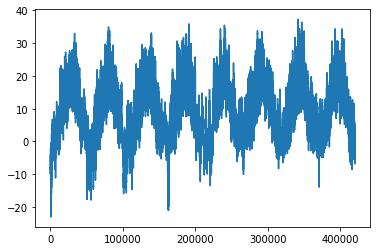

In [6]:
import matplotlib.pyplot as plt

temp = float_data[:, 1]
plt.plot(range(len(temp)), temp)

### Here's a more narrow plot of the first 10 days of temperature data.  Because the data is recorded every 10 minutes, you get 144 data points per day.

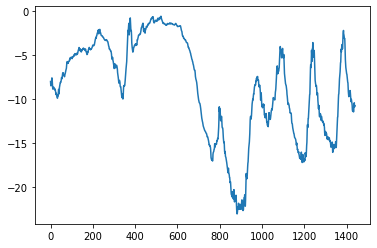

In [7]:
plt.plot(range(1440), temp[:1440])

### On this plot, you can see daily periodicity, especially evident for the last 4 days. Also note that this 10-day period must be coming from a fairly cold winter month.

### If you were trying to predict average temperature for the next month given a few months of past data, the problem would be easy, due to the reliable year-scale periodicity of the data. But how about looking at the data over a scale of days? Is this timeseries predictable at a daily scale? Let's find out.

## 6.3.2 Preparing the data

The formulation of the problem: Given data going so far back as ***lookback*** timesteps(a timestep is 10 min) and sampled every ***steps*** timesteps, can we predict the temperature in ***delay*** timesteps?

The following parameters will be used:

1) ***lookback = 720*** --- Observations will go back 5 days;

2) ***steps = 6*** --- Observations will be sampled at one data point per hour;

3) ***delay = 144*** ---Targets will be 24 hours in the future.

To get started, we need to do 2 things:

1) Process the data to a format that a neural network can ingest. Since the data is already numerical, we don't need vectorization, but each timeseries is on a different scale, we need to normalize each timeseries independently;

2) Write a Python generator that takes the current array of float data  and yields batches of data from the recent data, along with a target temperature in the future. Since the samples are **highly redundant**(samle N and sample N+1 will have most of their timesteps in common), it would be wasteful to explicitly allocate every sample. Instead, we will generate the samples on the fly using the original data.

### We first normarlize the data by $\frac{X-\mu}{\sigma}$. Note that we use the first 200,000 timesteps as training data, so we can only compute mean and std on this fraction of data(avoild information leaks) 

In [5]:
mean = float_data[:200000].mean(axis = 0)
std = float_data[:200000].std(axis = 0)

float_data -= mean
float_data /= std

In [6]:
float_data[:5]

array([[ 0.90014748, -1.93135845, -1.98211036, -1.86280029,  1.07285236,
        -1.30742164, -1.47375773, -0.79868641, -1.4762674 , -1.47815522,
         2.12375056, -0.72950452, -0.78067973, -0.27613603],
       [ 0.9060434 , -1.97541381, -2.02567   , -1.91582958,  1.07883061,
        -1.32042698, -1.4951961 , -0.80075238, -1.49502455, -1.49932141,
         2.17199852, -0.93124017, -0.88794488, -0.46317443],
       [ 0.90132666, -1.98671006, -2.03683914, -1.92001611,  1.10872183,
        -1.32302805, -1.49757814, -0.80281834, -1.49877598, -1.50167321,
         2.18235418, -1.27614304, -1.26122763, -0.05330633],
       [ 0.89896829, -1.96411757, -2.01338395, -1.88652392,  1.12665657,
        -1.31652538, -1.4832859 , -0.80488431, -1.48377026, -1.48756241,
         2.15764181, -1.17852902, -1.31700551,  0.25149699],
       [ 0.89896829, -1.95959907, -2.01003321, -1.8823374 ,  1.12067832,
        -1.31522484, -1.48090386, -0.80488431, -1.48377026, -1.48521061,
         2.15317004, -1.19

### Now we define the generator, it yields a tuple (samples, targets) where *samples* is one batch of input data and *targets* is the corresponding array of target temperatures. It takes the following arguments:

1) **data** --- original array of floating-point data, after normalization before;

2) **lookback** ---how many timesteps back the input data should go;

3) **delay** --- How many timesteps in the future the target should be;

4) **min_index, max_index** --- indices in the **data** array that delimit which timesteps to draw from, useful for keeping a segmentation of data for validation and test;

5) **shuffle** ---- whether or not to shuffle the samples

6) **batch_size** --- the number of samples per batch;

7) **step** --- The period, in timesteps at which you sample data. 6 for drawing one data point per hour

In [7]:
def generator(data, lookback,  delay, min_index, max_index,
              shuffle = False, batch_size = 128, step = 6):
    
    if max_index is None:
        max_index = len(data) - delay - 1
    
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(min_index + lookback, max_index, size = batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
        
        samples = np.zeros((len(rows), lookback // step, data.shape[-1]))
        targets = np.zeros((len(rows), ))
        
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        
        yield samples, targets

### Now let's use the abstract *generator* function to instantiate three generators: training, validation and testing. Each look at different temporal segments of the original data: training looks at the first 200,000 timesteps, validation looks at the following 100,000 and the test generator looks at the remainder.

In [8]:
lookback = 720
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data, lookback = lookback, delay = delay,
                      min_index = 0, max_index = 200000, shuffle = True, step = step, batch_size = batch_size)

val_gen = generator(float_data, lookback = lookback, delay = delay,
                      min_index = 200001, max_index = 300000, shuffle = True, step = step, batch_size = batch_size)

test_gen = generator(float_data, lookback = lookback, delay = delay,
                      min_index = 300000, max_index = None, shuffle = True, step = step, batch_size = batch_size)

val_steps = (300000 - 200001 - lookback) // 128 # How many steps to draw from val_gen in order to see the entire val_set
test_steps = (len(float_data) - 300001 - lookback) // 128

### 6.3.3 A common-sense, non-ML baseline

Before we use any deep-learning models to solve this prediction problem, let's first try a simple, common-sense approach. It will serve as a **sanity check**, and **establish a baseline you'll have to beat in order to demonstrate the useflness of more-advanced ML methods**.

A classic example is that of balanced classification tasks, where some classes are much more common than others. e.g. If your dataset contains 90% instances of class A and 10% class B, then a common-sense approach is to always predict A when presented with a new sample.

In this case, the temperature timeseries can safely be assumed to be **continuous (the temperatures tomorrow are likely to be close to the temperatures today)** as well as **periodical with a daily period**. Thus a common-sense approach is to **always predict that the temperature 24 hours from now will be equal to the temperature right now**.

### Let's evaluate this approach, using the mean absolute error (MAE) metric:

In [ ]:
np.mean(np.abs(preds - targets))

### Here's the evaluation loop:

In [12]:
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    
    print(np.mean(batch_maes))

In [13]:
evaluate_naive_method()

0.28955643358772803


### This returns an MAE of 0.29, but this is not the end, remember that the temperature data has been normalized, thus this number isn't immediately interpretable, we need to translate it back.

In [9]:
celsius_mae = 0.29 * std[1]

In [10]:
celsius_mae

2.5672247338393377

### That's a quite large MAE, now the game is to use our knowledge of deep learning to do better.

## 6.3.4 A basic ML approach

It's useful to try simple, cheap ML models (e.g. small densely connected networks) before looking into complicated and computationally expensive models such as RNNs. **This is the best way to make sure any further complexity you throw at the problem is legitimate and delivers real benefits**

The following pipeline shows a fully connected model that starts by flattening the data and runs it through two Dense layers. **Note the lack of activation function of the output layer, which is typical for a regression problem**. We still use MAE as metric, thus it will be comparable to the results before with a common-sense approach.

In [16]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape = (lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation = 'relu'))
model.add(layers.Dense(1))

model.compile(optimizer = RMSprop(), loss = 'mae')

Using TensorFlow backend.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [17]:
history = model.fit_generator(train_gen,
                              steps_per_epoch = 500,
                              epochs = 20,
                              validation_data = val_gen,
                              validation_steps = val_steps)

Epoch 1/20
500/500 [==============================] - 814s 2s/step - loss: 1.1532 - val_loss: 0.4614
Epoch 2/20
500/500 [==============================] - 779s 2s/step - loss: 0.3969 - val_loss: 0.3671
Epoch 3/20
500/500 [==============================] - 788s 2s/step - loss: 0.2881 - val_loss: 0.2866
Epoch 4/20
500/500 [==============================] - 783s 2s/step - loss: 0.2645 - val_loss: 0.3244
Epoch 5/20
500/500 [==============================] - 790s 2s/step - loss: 0.2537 - val_loss: 0.3072
Epoch 6/20
500/500 [==============================] - 804s 2s/step - loss: 0.2452 - val_loss: 0.3513
Epoch 7/20
500/500 [==============================] - 790s 2s/step - loss: 0.2385 - val_loss: 0.2980
Epoch 8/20
500/500 [==============================] - 793s 2s/step - loss: 0.2308 - val_loss: 0.2613
Epoch 9/20
500/500 [==============================] - 779s 2s/step - loss: 0.2262 - val_loss: 0.3448
Epoch 10/20
500/500 [==============================] - 770s 2s/step - loss: 0.2236 - val_lo

### Let's display the loss curves for validation and training 

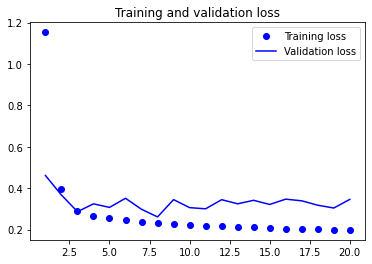

In [18]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Some of the validation losses are close to the no-learning baseline, but not reliably. This shows the merit of having this baseline in the first place: **it turns out to be not easy to outperform**. **You common sense contains a lot of valuable information that a ML model does not have access to**.

### You may wonder, if a simple, well-performing model exists to go from the data to the targets (the common-sense baseline), why doesn’t the model you’re training find it and improve on it? 

Because this simple solution isn’t what your training setup is looking for. The space of models in which you’re searching for a solution—that is, your hypothesis space—is **the space of all possible two-layer networks with the configuration you defined**. These networks are already fairly complicated. **When you are searching for a space of complicated models, the simple, well-performing baseline may be unlearnable, even if it's technically part of the hypothesis space**.

### This is a pretty significant limitation of ML in general: unless the learning algorithm is hardcoded to look for a specific kind of simple model, parameter learning can sometimes fail to find a simple solution to a simple problem.

## 6.3.5 A first recurrent baseline

The first fully connected approach didn't do well, but that doesn't mean ML isn't applicable to this problem. **The previous approach first flatten the timeseries, which removed the notion of time from the input data**. Let's instead look at the data as what it is: **a sequence, where causality and order matter**.

We'll try a reurrent-sequence processing model --- it should be the perfect fit for such sequence data, precisely because **it exploits the temporal ordering if data points**, unlike the first approach.

Instead of the LSTM layer introduced in the previous section, we use the **GRU layer**, developed by Chung et al. in 2014.

**Gated recurrent unit ( GRU )** layers work using the same principle as LSTM , but they’re somewhat **streamlined and thus cheaper to run (although they may not have as much representational power as LSTM )**. This trade-off between computational expensiveness and representational power is seen everywhere in machine learning.

In [11]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32, input_shape = (None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer = RMSprop(), loss = 'mae')

Using TensorFlow backend.
W0712 17:31:39.625923 139912526534400 deprecation_wrapper.py:119] From /usr/local/miniconda3/envs/dl/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0712 17:31:39.793858 139912526534400 deprecation_wrapper.py:119] From /usr/local/miniconda3/envs/dl/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0712 17:31:39.840553 139912526534400 deprecation_wrapper.py:119] From /usr/local/miniconda3/envs/dl/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0712 17:31:40.708370 139912526534400 deprecation_wrapper.py:119] From /usr/local/miniconda3/envs/dl/lib/python3.6/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Plea

In [12]:
history = model.fit_generator(train_gen,
                              steps_per_epoch = 500,
                              epochs = 20,
                              validation_data = val_gen,
                              validation_steps = val_steps,
                              verbose = 2)

W0712 17:31:47.676105 139912526534400 deprecation.py:323] From /usr/local/miniconda3/envs/dl/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0712 17:31:48.225116 139912526534400 deprecation_wrapper.py:119] From /usr/local/miniconda3/envs/dl/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0712 17:31:48.237785 139912526534400 deprecation_wrapper.py:119] From /usr/local/miniconda3/envs/dl/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



Epoch 1/20
 - 200s - loss: 0.3030 - val_loss: 0.2773
Epoch 2/20
 - 174s - loss: 0.2865 - val_loss: 0.2693
Epoch 3/20
 - 174s - loss: 0.2785 - val_loss: 0.2650
Epoch 4/20
 - 175s - loss: 0.2741 - val_loss: 0.2603
Epoch 5/20
 - 175s - loss: 0.2664 - val_loss: 0.2622
Epoch 6/20
 - 172s - loss: 0.2629 - val_loss: 0.2664
Epoch 7/20
 - 174s - loss: 0.2600 - val_loss: 0.2676
Epoch 8/20
 - 174s - loss: 0.2542 - val_loss: 0.2649
Epoch 9/20
 - 175s - loss: 0.2498 - val_loss: 0.2676
Epoch 10/20
 - 174s - loss: 0.2437 - val_loss: 0.2719
Epoch 11/20
 - 174s - loss: 0.2404 - val_loss: 0.2803
Epoch 12/20
 - 175s - loss: 0.2365 - val_loss: 0.2818
Epoch 13/20
 - 173s - loss: 0.2302 - val_loss: 0.2824
Epoch 14/20
 - 174s - loss: 0.2281 - val_loss: 0.2835
Epoch 15/20
 - 172s - loss: 0.2241 - val_loss: 0.2919
Epoch 16/20
 - 173s - loss: 0.2188 - val_loss: 0.2906
Epoch 17/20
 - 174s - loss: 0.2172 - val_loss: 0.2975
Epoch 18/20
 - 174s - loss: 0.2133 - val_loss: 0.2969
Epoch 19/20
 - 174s - loss: 0.2098 - 

### The results have been much better, significantly beating the common-sense baseline. The new validation MAE of ~0.265 (before significantly overfitting) translates to a mean absolute error of 2.35 oC after denormalization. That's a solid gain on the initial error of 2.57 oC

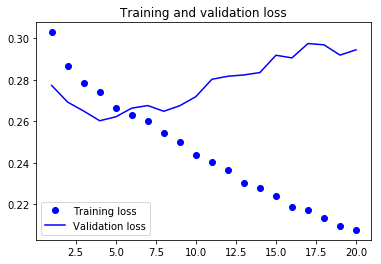

In [14]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## 6.3.6 Using recurrent dropout to fight overfitting

We've already familiar with the classic technique for fighting overfitting: dropout, which randomly zeros out input units of a layer in order to break happenstance correlations in the training data that the layer is exposed to. 

But how to correctly apply dropout in recurrent networks isn’t a trivial question. It has long been known that **applying dropout before a recurrent layer hinders learning rather than helping with regularization**. 

Yarin Gal(2015) determined the proper way to use dropout with a recurrent network:
**the same dropout mask(same pattern of dropped units) should be applied at every timestep, instead of a dropout mask that varies randomly from timestep to timestep**.

What's more, in order to regularize the representations formed by the recurrent gates of layers such as GRU and LSTM, **a temporally constant dropout mask should be applied to the inner recurrent activations of the layer(a *recurrent* dropout mask)**. Using the same dropout mask at every timestep allows the network to properly propagate learning error through time; a temporally **random** dropout mask would **disrupt this error signal and be harmful to the learning process.**

This mechanism has been built in Keras recurrent layers fortunately. Every recurrent layer in Keras has **2 dropout-related arguments**:
### 1) *dropout*:  a float specifying the dropout rate for *input units* of the layer;
### 2) *recurrent_dropout*: specifying the dropout rate of the *recurrent units*.

### Because networks being regularized with dropout always take longer to fully converge, we train the network for twice as many epochs.

In [ ]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32, dropout = 0.2, recurrent_dropout = 0.2,
                     input_shape = (None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer = RMSprop() loss = 'mae')

In [ ]:
history = model.fit_generator(train_gen,
                              steps_per_epoch = 500,
                              epochs = 40,
                              validation_data = val_gen,
                              validation_steps = val_steps,
                              verbose = 2)

In [ ]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Figure shows that we're no longer overfitting during the first 30 epochs. But although we have more stable evaluation scores, the best scores aren't much lower than they were previously.

## 6.3.7 Stacking recurrent layers

Because we're no longer overfitting but seem to have hit a performance bottleneck, we should consider **increasing the capacity of the network**.

### It's generally a good idea to increase the capacity of the network until overfitting becomes the primary obstacle(assuming we've already taking basic steps to mitigate overfitting, such as using dropout). As long as we are not overfitting too badly, we are likely under capacity.

Increasing network capacity is typically done by **increasing the number of units in the layers or adding more layers**. **Recurrent layer stacking** is a classic way to build more powerful recurrent networks.

To stack recurrent layers on top of each other in Keras, **all intermediate layers should return their full sequence of outputs**(a 3D tensor) rather than their output at the last timestep.(**return_sequences = True**)

In [ ]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32, dropout=0.1, recurrent_dropout=0.5,
                     return_sequences=True, input_shape=(None, float_data.shape[-1])))

model.add(layers.GRU(64, activation='relu',
                     dropout=0.1, recurrent_dropout=0.5))

model.add(layers.Dense(1))

model.compile(optimizer = RMSprop(), loss = 'mae')

In [ ]:
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps,
                              verbose = 2)

In [ ]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

The figure shows that the added layer does improve the results a bit, though not significantly. You can draw two conclusions:

1) Because you’re still not overfitting too badly, you could safely increase the size of your layers in a quest for validation-loss improvement. This has a **non-negligible computational cost**, though.

2) Adding a layer didn’t help by a significant factor, so you may be seeing **diminishing returns from increasing network capacity** at this point.

## 6.3.8 Using bidirectional RNNs

***Bidirectional RNNS*** is frequently used in natual-language processing --- someone call it the Swiss Army knife of deep learning for NLP.

**RNN s are notably order dependent, or time dependent**: they process the timesteps of their input sequences in order, and shuffling or reversing the timesteps can completely change the representations the RNN extracts from the sequence. **This is precisely the reason they perform well on problems where order is meaningful**.

###  A bidirectional RNN exploits the order sensitivity of RNNs: it consists of using two regular RNNs, each of which processes the input sequence in one direction (chronologically and antichronologically), and then merging their representations. By processing a sequence both ways, a bidirectional RNN can catch patterns that may be overlooked by a unidirectional RNN.

Before, we process sequences in chronological order(old timesteps first) without questioning about the settings. **Could the RNNs have performed well enough if they processed input sequences in antichronological order, for instance(newer timesteps first)?**

Let's try it in practice and see what happens.(just replace the last line of the generator with **yield samples[:, ::-1, :], targets** to form a variant of the generator,  then train the same one-GRU-layer network.

In [ ]:
def reverse_generator(data, lookback,  delay, min_index, max_index,
              shuffle = False, batch_size = 128, step = 6):
    
    if max_index is None:
        max_index = len(data) - delay - 1
    
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(min_index + lookback, max_index, size = batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
        
        samples = np.zeros((len(rows), lookback // step, data.shape[-1]))
        targets = np.zeros((len(rows), ))
        
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        
        yield samples[:, ::-1, :], targets

In [ ]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

rev_train_gen = reverse_generator(float_data, lookback = lookback, delay = delay,
                      min_index = 0, max_index = 200000, shuffle = True, step = step, batch_size = batch_size)

rev_val_gen = reverse_generator(float_data, lookback = lookback, delay = delay,
                      min_index = 200001, max_index = 300000, shuffle = True, step = step, batch_size = batch_size)

rev_test_gen = reverse_generator(float_data, lookback = lookback, delay = delay,
                      min_index = 300000, max_index = None, shuffle = True, step = step, batch_size = batch_size)

val_steps = (300000 - 200001 - lookback) # How many steps to draw from val_gen in order to see the entire val_set
test_steps = (len(float_data) - 300001 - lookback)

In [ ]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32, input_shape = (None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer = RMSprop(), loss = 'mae')

In [ ]:
history = model.fit_generator(rev_train_gen,
                              steps_per_epoch = 500,
                              epochs = 20,
                              validation_data = rev_val_gen,
                              validation_steps = val_steps,
                              verbose = 2)

In [ ]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### The reversed-order GRU strongly underperforms even the common-sense baseline, indicating that in this case, chronological processing is important to the success of your approach.

This makes sense: the underlying layer **GRU will typically better at remembering the recent past than the distant past, and naturally the more recent weather data points are more predictive than older data points for the problem** (that’s what makes the common-sense baseline fairly strong). 

Importantly, not all chronological version of the layer will outperform the reverse-order version for many other problems, like natural language: intuitively, **the importance of a word in understanding a sentence isn't usually dependent on its position in the sentence**.

### Let's try the same trick on LSTM IMDB example.

In [ ]:
from keras.datasets import imdb
from keras.preprocessing import sequence

max_features = 10000
maxlen = 500

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

#reverse sequences
x_train = [x[::-1] for x in x_train]
x_test = [x[::-1] for x in x_test]

x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)

In [ ]:
from keras import layers
from keras.models import Sequential

model = Sequential()
model.add(layers.Embedding(max_features, 128))
model.add(layers.LSTM(32))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])

In [ ]:
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

We get performance nearly identical to that of the chronological-order LSTM. This remarkably confirms the hypotheis that: **although the word order *does* matter in understanding language, *which* order you use is not crucial**.

Importantly, an RNN trained on reversed sequences will learn different representations than one trained on the original sequences. In machine learning, **representations that are *different* yet *useful* are always worth exploiting, and the more they differ, the better: they offer a new angle from which to look at your data, capturing aspects of the data that were missed by other approaches, and thus they can help boost performance on a task**. This is the intuition behind ***ensembling***, we will discuss it in Chapter 7.

### We use the *Bidirectional* layer in Keras, which takes as its first argument a recurrent layer instance.
**Bidirectional** creates a second, separate instance of this recurrent layer and uses these two instances processing the input sequences in chronological and reversed order, respectively.

In [ ]:
# IMDB example with bidirectional LSTM

model = Sequential()
model.add(layers.Embedding(max_features, 32))
model.add(layers.Bidirectional(layers.LSTM(32)))
model.add(layers.Dense(1, activation = 'sigmoid'))

model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = ['acc'])

history = model.fit(x_train, y_train,
                    epochs = 10,
                    batch_size = 128,
                    validation_split = 0.2)

It performs slightly better than the regular LSTM you tried in the previous section, achieving over 89% validation accuracy. It also seems to overfit more quickly, which is unsurprising **because a bidirectional layer has twice as many parameters as a chronological LSTM**. With some regularization, the bidirectional approach would likely be a
strong performer on this task.

Let's try the same approach on the temperature-prediction problem.

In [ ]:
# temperature-prediction with bidirectioanl GRU

from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Bidirection(layers.GRU(32, input_shape=(None, float_data.shape[-1]))))
model.add(layers.Dense(1))

model.compile(optimizer = RMSprop(), loss = 'mae')

history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

This performs about as well ad regular GRU layer, which is easy to understand: all the predictive capacity must come from the chronological half of the network, because the reverse-order half is known to be severely underperforming on this task.

### As always, deep learning is more an art than a science. We can provide general guildlines on a given problem, but ultimately, every problem is unique, you'll have to evaluate different stategies empirically. 